Untuk uji coba dapat dilakukan konfigurasi: <br>
- variabel MODEL_PATH, threshold, dan label path

In [1]:
import re
import cv2
import tensorflow as tf
import numpy as np

In [2]:
CAMERA_WIDTH = 320
CAMERA_HEIGHT = 320

def load_labels(path='labels.txt'):
    """Loads the labels file. Supports files with or without index numbers."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        labels = {}
        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            # print(pair)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number] = pair[0].strip()
    return labels

def set_input_tensor(interpreter, image):
    """Sets the input tensor."""
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = np.expand_dims((image-255)/255, axis=0)


def get_output_tensor(interpreter, index):
    """Returns the output tensor at the given index."""
    output_details = interpreter.get_output_details()[index]
    tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
    return tensor


def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()
    # Get all output details [harusnya ini yang bener; boxes, classes, scores, dan count]
    # boxes = get_output_tensor(interpreter, 0)
    # classes = get_output_tensor(interpreter, 1)
    # scores = get_output_tensor(interpreter, 2)
    # count = get_output_tensor(interpreter, 3)
    
    scores = get_output_tensor(interpreter, 0)
    boxes = get_output_tensor(interpreter, 1)
    count = int(get_output_tensor(interpreter, 2))
    classes = get_output_tensor(interpreter, 3)
    
    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
            }
            results.append(result)
    return results

In [3]:
labels = load_labels()
MODEL_PATH = r'.\Tensorflow\workspace\models\my_ssd_mobnet_3\tfliteexport\saved_model\detect.tflite'
interpreter = tf.lite.Interpreter(MODEL_PATH)
interpreter.allocate_tensors()
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

## Using image

In [4]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt 

In [5]:
labels

{0: 'botolkaca',
 1: 'botolplastik',
 2: 'kaleng',
 3: 'kardus',
 4: 'kertas',
 5: 'plastik',
 6: 'sedotan'}

63 152 206 220


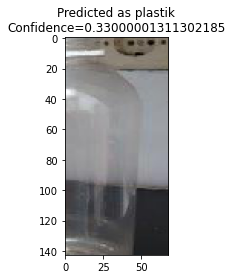

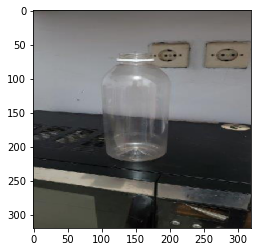

In [16]:
IMAGE_PATH = r'.\Tensorflow\workspace\images\train\20220514_181114.jpg'
INPUT_SIZE = 320
nrows = 3
threshold = .3
scater_color = 'red'

images_load = image.load_img(IMAGE_PATH, target_size=(INPUT_SIZE, INPUT_SIZE))

x = image.img_to_array(images_load)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

res = detect_objects(interpreter, images, threshold)

images = images[0]
images = images/255.

for idx, data in enumerate(res):
    
    y_min, x_min, y_max, x_max = data['bounding_box']
    x_min = int(max(1, x_min*INPUT_SIZE))
    x_max = int(min(INPUT_SIZE, x_max*INPUT_SIZE))
    y_min = int(max(1, y_min*INPUT_SIZE))
    y_max = int(min(INPUT_SIZE, y_max*INPUT_SIZE))
    
    print(x_min, y_min, x_max, y_max)
    # plt.scatter(x_min, y_min, color='red')
    # plt.scatter(x_max, y_min, color='blue')
    # plt.scatter(x_min, y_max, color='green')
    # plt.scatter(x_max, y_max, color='purple')
    
    class_id = data['class_id']
    score_id = data['score']
    
    plt.title(f"Predicted as {labels[class_id]}\nConfidence={round(score_id, 2)}")
    plt.imshow(images[x_min:x_max, y_min :y_max, :])
    plt.show()
    
    # break

plt.imshow(images)
plt.show()

## Using webcam

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (320,320))
    threshold = .5
    res = detect_objects(interpreter, img, threshold)
    print(res)

    for result in res:
        ymin, xmin, ymax, xmax = result['bounding_box']
        xmin = int(max(1,xmin * CAMERA_WIDTH))
        xmax = int(min(CAMERA_WIDTH, xmax * CAMERA_WIDTH))
        ymin = int(max(1, ymin * CAMERA_HEIGHT))
        ymax = int(min(CAMERA_HEIGHT, ymax * CAMERA_HEIGHT))
        
        cv2.rectangle(frame,(xmin, ymin),(xmax, ymax),(0,255,0),3)
        cv2.putText(frame,labels[int(result['class_id'])],(xmin, min(ymax, CAMERA_HEIGHT-20)), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),2,cv2.LINE_AA) 

    cv2.imshow('Deteksi Sampah!', frame)

    if cv2.waitKey(10) & 0xFF ==ord('q'):
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()